In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, accuracy_score, f1_score, recall_score
from pathlib import Path
from imblearn.over_sampling import SMOTE


In [3]:
PROJECT_ROOT = Path().resolve().parent
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

df = pd.read_csv("../data/processed/clinicaltrials_features_ml.csv")

df.shape
df.head()


,NCTId,PrimaryConditionMesh,DurationPrimaryDays,DurationCompletionDays,StartYear,StartMonth,StudyFirstSubmitYear,LastUpdateYear,PrimaryInterventionMesh,EnrollmentCount,...,PrimaryCountry_reduced_China,PrimaryCountry_reduced_Egypt,PrimaryCountry_reduced_France,PrimaryCountry_reduced_Germany,PrimaryCountry_reduced_Japan,PrimaryCountry_reduced_Other,PrimaryCountry_reduced_South Korea,PrimaryCountry_reduced_United Kingdom,PrimaryCountry_reduced_United States,PrimaryCountry_reduced_Unknown
0,NCT01315821,"Enterocolitis, Necrotizing",303.0,303.0,2011,2,2011,2011,Unknown,220.0,...,False,False,False,False,False,True,False,False,False,False
1,NCT04551521,Neoplasm Metastasis,1174.0,1174.0,2021,10,2020,2025,Vemurafenib,72.0,...,False,False,False,True,False,False,False,False,False,False
2,NCT04086121,"Dermatitis, Atopic",582.0,883.0,2019,9,2019,2025,spesolimab,14.0,...,False,False,False,False,False,False,False,False,True,False
3,NCT01181921,Alzheimer Disease,31.0,31.0,2011,5,2010,2014,Galantamine,1.0,...,False,False,False,False,False,True,False,False,False,False
4,NCT05435014,"Carcinoma, Hepatocellular",1386.0,1386.0,2022,9,2021,2024,Ethiodized Oil,90.0,...,False,False,False,False,False,True,False,False,False,False


In [4]:
df["target"] = np.nan

df.loc[df["OverallStatus_COMPLETED"] == 1, "target"] = 1
df.loc[
    df[["OverallStatus_TERMINATED",
        "OverallStatus_WITHDRAWN",
        "OverallStatus_SUSPENDED"]].sum(axis=1) > 0,
    "target"
] = 0

df = df.dropna(subset=["target"]).copy()
df["target"] = df["target"].astype(int)

df["target"].value_counts(normalize=True)


target
1    0.813371
0    0.186629
Name: proportion, dtype: float64

In [5]:
X = df.drop(columns=["target", "NCTId","PrimaryConditionMesh","PrimaryInterventionMesh","OverallStatus_TERMINATED",
                     "OverallStatus_COMPLETED","OverallStatus_WITHDRAWN","OverallStatus_SUSPENDED"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# Crear muestra del 10% de X_train para tuning
X_tuned, _, y_tuned, _ = train_test_split(
    X_train, y_train,
    train_size=0.10,
    stratify=y_train,
    random_state=42
)

In [7]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC: 0.8531008499327694
              precision    recall  f1-score   support

           0       0.85      0.46      0.59      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.87      0.72      0.76     28956
weighted avg       0.88      0.88      0.87     28956



In [8]:
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10,],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

rf_random.fit(X_tuned, y_tuned)
best_params = rf_random.best_params_

rf_best = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [9]:
rf_best.fit(X_train, y_train)
y_pred_best = rf_best.predict(X_test)
y_proba_best = rf_best.predict_proba(X_test)[:, 1]

print("AUC (RF tuned):", roc_auc_score(y_test, y_proba_best))
print(classification_report(y_test, y_pred_best))

AUC (RF tuned): 0.8394072778215814
              precision    recall  f1-score   support

           0       0.89      0.41      0.56      5404
           1       0.88      0.99      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.89      0.70      0.75     28956
weighted avg       0.88      0.88      0.86     28956



In [10]:
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)
y_proba = hgb.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC: 0.8589258269777519
              precision    recall  f1-score   support

           0       0.85      0.47      0.60      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.89     28956
   macro avg       0.87      0.72      0.77     28956
weighted avg       0.88      0.89      0.87     28956



In [11]:
param_dist_hgb = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, None],
    "min_samples_leaf": [10, 20, 50],
    "l2_regularization": [0.0, 0.1, 1.0]
}

hgb_random = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist_hgb,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

hgb_random.fit(X_tuned, y_tuned)
hgb_random.best_params_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'min_samples_leaf': 50,
 'max_depth': 3,
 'learning_rate': 0.1,
 'l2_regularization': 0.1}

In [12]:
hgb_best = hgb_random.best_estimator_

hgb_best.fit(X_train, y_train)

y_pred = hgb_best.predict(X_test)
y_proba = hgb_best.predict_proba(X_test)[:, 1]

print("AUC (HGB tuned):", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC (HGB tuned): 0.8454659299648207
              precision    recall  f1-score   support

           0       0.87      0.44      0.58      5404
           1       0.88      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.88      0.71      0.76     28956
weighted avg       0.88      0.88      0.87     28956



In [13]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC: 0.860665622586329
              precision    recall  f1-score   support

           0       0.85      0.47      0.61      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.89     28956
   macro avg       0.87      0.73      0.77     28956
weighted avg       0.88      0.89      0.87     28956



In [14]:
param_dist_xgb = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 1],
    "colsample_bytree": [0.7, 1],
    "gamma": [0, 1, 5]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

xgb_random.fit(X_tuned, y_tuned)
best_params_xgb = xgb_random.best_params_
best_params_xgb

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'subsample': 0.7,
 'n_estimators': 200,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.7}

In [15]:
xgb_best = XGBClassifier(
    **best_params_xgb,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",   # recomendable para velocidad
    n_jobs=-1,
    random_state=42
)

xgb_best.fit(X_train, y_train)

y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:, 1]

print("AUC (XGB tuned):", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC (XGB tuned): 0.8555358134410802
              precision    recall  f1-score   support

           0       0.86      0.45      0.59      5404
           1       0.89      0.98      0.93     23552

    accuracy                           0.88     28956
   macro avg       0.87      0.72      0.76     28956
weighted avg       0.88      0.88      0.87     28956



In [16]:
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Antes:", y_train.value_counts())
print("Después:", y_train_sm.value_counts())


Antes: target
1    94207
0    21616
Name: count, dtype: int64
Después: target
1    94207
0    94207
Name: count, dtype: int64


In [17]:
xgb_sm = XGBClassifier(
    **best_params_xgb,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_sm.fit(X_train_sm, y_train_sm)

y_pred_sm = xgb_sm.predict(X_test)
y_proba_sm = xgb_sm.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score

auc_sm = roc_auc_score(y_test, y_proba_sm)
acc_sm = accuracy_score(y_test, y_pred_sm)
f1_sm = f1_score(y_test, y_pred_sm)

recall_0_sm = recall_score(y_test, y_pred_sm, pos_label=0)
recall_1_sm = recall_score(y_test, y_pred_sm, pos_label=1)

print("AUC:", auc_sm)
print("Accuracy:", acc_sm)
print("F1:", f1_sm)
print("Recall_0 (Fracaso):", recall_0_sm)
print("Recall_1 (Éxito):", recall_1_sm)


AUC: 0.8404121883850126
Accuracy: 0.8794723028042547
F1: 0.9291543177296903
Recall_0 (Fracaso): 0.4774241302738712
Recall_1 (Éxito): 0.9717221467391305


In [18]:
rf_best = RandomForestClassifier(
    **rf_random.best_params_,
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train, y_train)


xgb_best = XGBClassifier(
    **xgb_random.best_params_,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)
xgb_best.fit(X_train, y_train)

hgb_best = HistGradientBoostingClassifier(
    **hgb_random.best_params_,
    random_state=42
)
hgb_best.fit(X_train, y_train)


models = {
    "Random Forest": rf_best,
    "HistGradientBoosting": hgb_best,
    "XGBoost": xgb_best
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Recall por clase
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    
    results.append([name, auc, acc, f1, recall_0, recall_1])

results_df = pd.DataFrame(
    results,
    columns=["Modelo", "AUC", "Accuracy", "F1", "Recall_0 (Fracasos)", "Recall_1 (Éxito)"]
).sort_values("AUC", ascending=False)

results_df


,Modelo,AUC,Accuracy,F1,Recall_0 (Fracasos),Recall_1 (Éxito)
2,XGBoost,0.855536,0.883893,0.932302,0.452258,0.982931
1,HistGradientBoosting,0.845466,0.883202,0.932042,0.440785,0.984715
0,Random Forest,0.839407,0.880681,0.930948,0.409141,0.988876


In [19]:
rf_importances = pd.Series(
    rf_best.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

rf_importances.head(20)

EnrollmentCount                         0.712454
StartYear                               0.038033
AgeRange                                0.026176
DurationCompletionDays                  0.023701
PrimaryCountry_reduced_Unknown          0.022920
DurationPrimaryDays                     0.022296
MaxAgeYears                             0.019141
StudyFirstSubmitYear                    0.017010
PrimaryCountry_reduced_United States    0.013024
LastUpdateYear                          0.013015
SummaryLength                           0.008697
IsRandomized                            0.008244
Phase_PHASE1                            0.007305
MinAgeYears                             0.007287
LeadSponsorClass_OTHER                  0.006773
LeadSponsorClass_INDUSTRY               0.005579
DesignMasking_NONE                      0.005327
Phase_PHASE2                            0.005140
PrimaryCountry_reduced_Other            0.005079
IsBlinded                               0.004416
dtype: float64

In [20]:
booster = xgb_best.get_booster()  # mejor el modelo final reentrenado
importance_dict = booster.get_score(importance_type="gain")

importance_df = pd.DataFrame({
    "Feature": list(importance_dict.keys()),
    "Gain": list(importance_dict.values())
}).sort_values(by="Gain", ascending=False)

importance_df.head(20)

,Feature,Gain
6,EnrollmentCount,364.015961
45,PrimaryCountry_reduced_Unknown,87.219513
24,Phase_PHASE1,63.905243
44,PrimaryCountry_reduced_United States,48.641586
15,IsRandomized,34.667088
11,MaxAgeYears,33.963303
12,AgeRange,31.502096
0,DurationPrimaryDays,26.626236
40,PrimaryCountry_reduced_Japan,26.456669
19,LeadSponsorClass_INDUSTRY,26.358427


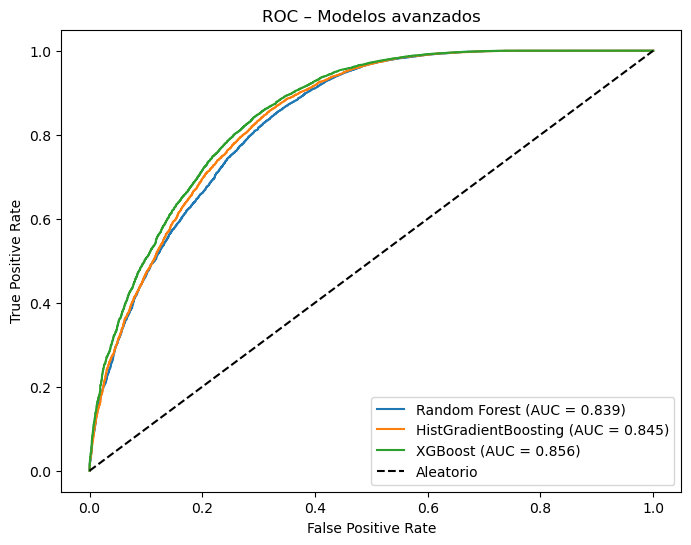

In [21]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_value = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_value:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Modelos avanzados")
plt.legend()
plt.savefig(FIGURES_DIR / "roc_advanced.png", dpi=300, bbox_inches="tight")
plt.show()


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    recall_score, precision_score, f1_score, accuracy_score
)

thresholds = np.arange(0.1, 0.9, 0.02)

rows = []

for t in thresholds:
    y_pred_adj = (y_proba_sm > t).astype(int)
    
    recall_0 = recall_score(y_test, y_pred_adj, pos_label=0)
    recall_1 = recall_score(y_test, y_pred_adj, pos_label=1)
    
    precision_0 = precision_score(y_test, y_pred_adj, pos_label=0, zero_division=0)
    precision_1 = precision_score(y_test, y_pred_adj, pos_label=1, zero_division=0)
    
    f1 = f1_score(y_test, y_pred_adj)
    acc = accuracy_score(y_test, y_pred_adj)
    
    rows.append({
        "threshold": t,
        "recall_0": recall_0,
        "recall_1": recall_1,
        "precision_0": precision_0,
        "precision_1": precision_1,
        "f1": f1,
        "accuracy": acc
    })

threshold_df = pd.DataFrame(rows)
threshold_df_sorted = threshold_df.sort_values("recall_0", ascending=False)
threshold_df_sorted.head(20)


,threshold,recall_0,recall_1,precision_0,precision_1,f1,accuracy
39,0.88,0.889896,0.485649,0.284169,0.950553,0.642855,0.561093
38,0.86,0.854922,0.569209,0.312881,0.944750,0.710402,0.622531
37,0.84,0.818653,0.639564,0.342600,0.938914,0.760854,0.672987
36,0.82,0.783679,0.697903,0.373128,0.933602,0.798727,0.713911
35,0.80,0.752406,0.749915,0.408397,0.929579,0.830137,0.750380
34,0.78,0.723353,0.793903,0.446080,0.925964,0.854863,0.780736
33,0.76,0.692820,0.830163,0.483471,0.921742,0.873559,0.804531
32,0.74,0.663768,0.859502,0.520157,0.917634,0.887617,0.822973
31,0.72,0.640266,0.883704,0.558155,0.914576,0.898875,0.838272
30,0.70,0.617135,0.902981,0.593416,0.911339,0.907140,0.849634


In [23]:
t = 0.88
y_pred_t = (y_proba_sm > t).astype(int)

print("Recall_0:", recall_score(y_test, y_pred_t, pos_label=0))
print("Recall_1:", recall_score(y_test, y_pred_t, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_pred_t))
print("F1:", f1_score(y_test, y_pred_t))


Recall_0: 0.8898963730569949
Recall_1: 0.485648777173913
Accuracy: 0.5610926923608233
F1: 0.6428551355908388


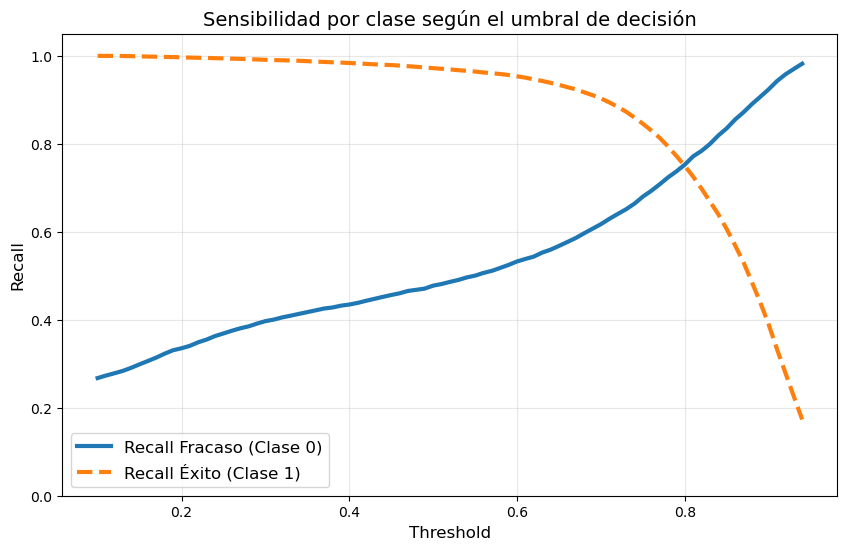

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Probabilidades del modelo entrenado con SMOTE
# (asegúrate de tener y_proba_sm calculado anteriormente)
thresholds = np.arange(0.1, 0.95, 0.01)

recalls_0 = []
recalls_1 = []

for t in thresholds:
    y_pred_t = (y_proba_sm > t).astype(int)
    recalls_0.append(recall_score(y_test, y_pred_t, pos_label=0))
    recalls_1.append(recall_score(y_test, y_pred_t, pos_label=1))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls_0, label="Recall Fracaso (Clase 0)", linewidth=3)
plt.plot(thresholds, recalls_1, label="Recall Éxito (Clase 1)", linewidth=3, linestyle="--")

plt.title("Sensibilidad por clase según el umbral de decisión", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.ylim(0, 1.05)
plt.savefig(FIGURES_DIR / "recall_threshold.png", dpi=300, bbox_inches="tight")


plt.show()


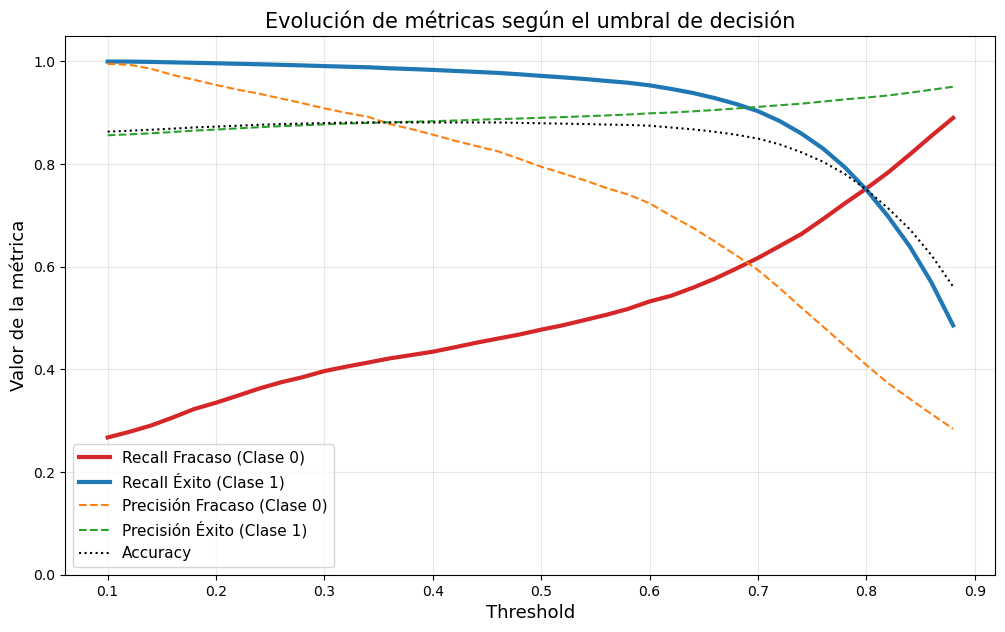

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# Lista de thresholds que ya estabas usando
thresholds = np.arange(0.1, 0.9, 0.02)

recall_0_list = []
recall_1_list = []
precision_0_list = []
precision_1_list = []
f1_list = []
accuracy_list = []

for t in thresholds:
    y_pred_adj = (y_proba_sm > t).astype(int)
    
    recall_0_list.append(recall_score(y_test, y_pred_adj, pos_label=0))
    recall_1_list.append(recall_score(y_test, y_pred_adj, pos_label=1))
    
    precision_0_list.append(precision_score(y_test, y_pred_adj, pos_label=0, zero_division=0))
    precision_1_list.append(precision_score(y_test, y_pred_adj, pos_label=1, zero_division=0))

    f1_list.append(f1_score(y_test, y_pred_adj))
    accuracy_list.append(accuracy_score(y_test, y_pred_adj))

plt.figure(figsize=(12, 7))

plt.plot(thresholds, recall_0_list, label="Recall Fracaso (Clase 0)", linewidth=3, color="#d62728")
plt.plot(thresholds, recall_1_list, label="Recall Éxito (Clase 1)", linewidth=3, color="#1f77b4")

plt.plot(thresholds, precision_0_list, label="Precisión Fracaso (Clase 0)", linestyle="--", color="#ff7f0e")
plt.plot(thresholds, precision_1_list, label="Precisión Éxito (Clase 1)", linestyle="--", color="#2ca02c")

plt.plot(thresholds, accuracy_list, label="Accuracy", linestyle=":", color="black")

plt.title("Evolución de métricas según el umbral de decisión", fontsize=15)
plt.xlabel("Threshold", fontsize=13)
plt.ylabel("Valor de la métrica", fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(0, 1.05)
plt.savefig(FIGURES_DIR / "metrics_threshold.png", dpi=300, bbox_inches="tight")

plt.show()


In [29]:
df["target"].value_counts(dropna=False, normalize=True)

target
1.0    0.813371
0.0    0.186629
Name: proportion, dtype: float64

In [27]:
df["target"].value_counts()

target
1.0    117759
0.0     27020
Name: count, dtype: int64

In [28]:
df.corr(numeric_only=True)["target"].sort_values(ascending=False).head(20)

target                                   1.000000
OverallStatus_COMPLETED                  1.000000
IsRandomized                             0.086881
PrimaryCountry_reduced_Other             0.076752
LeadSponsorClass_INDUSTRY                0.073563
IsBlinded                                0.066879
Phase_PHASE1                             0.059107
PrimaryCountry_reduced_South Korea       0.047230
PrimaryCountry_reduced_Japan             0.046717
PrimaryCountry_reduced_Egypt             0.045427
PrimaryCountry_reduced_China             0.041138
Sex_MALE                                 0.040740
Phase_PHASE3                             0.038529
DesignMasking_SINGLE                     0.032580
Phase_PHASE4                             0.026312
DesignMasking_Unknown                    0.022761
PrimaryCountry_reduced_United Kingdom    0.021019
IsPediatric                              0.020955
DesignMasking_QUADRUPLE                  0.020172
EnrollmentCount                          0.020141


In [30]:
df.corr(numeric_only=True)["target"].sort_values().head(20)

OverallStatus_TERMINATED               -0.813645
OverallStatus_WITHDRAWN                -0.479007
OverallStatus_SUSPENDED                -0.144149
StartYear                              -0.121151
AgeRange                               -0.108450
MaxAgeYears                            -0.099847
PrimaryCountry_reduced_United States   -0.085196
PrimaryCountry_reduced_Unknown         -0.084553
LastUpdateYear                         -0.083445
StudyFirstSubmitYear                   -0.078683
LeadSponsorClass_OTHER                 -0.078112
Phase_PHASE2                           -0.072339
DesignMasking_NONE                     -0.071545
Phase_PHASE1 / PHASE2                  -0.058040
SummaryLength                          -0.033002
Sex_ALL                                -0.030341
DurationPrimaryDays                    -0.013812
IsElderly                              -0.012159
Phase_PHASE2 / PHASE3                  -0.008523
StartMonth                             -0.006820
Name: target, dtype: